# ICLR Workshop Challenge #1: CGIAR Computer Vision for Crop Disease

Amritha Musipatla and Grisam Shah  
CU_sm3773_gvs2110

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

## Imports and packages

In [2]:
import os
import csv
import random
import numpy as np
import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split

# Package to show progress bars on loops
from tqdm import tqdm_notebook as tqdm

from fastai.vision import *
import torchvision.models as tvmodels
from torch.nn.functional import cross_entropy


## Data Observations

Check class distribution in training data.

stem_rust :	 376
healthy_wheat :	 365
leaf_rust :	 358

Total train images:	 1099


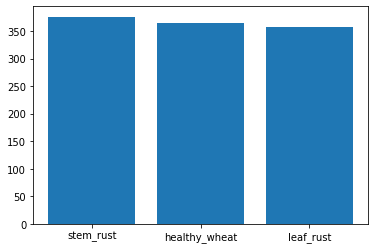

In [3]:
base_dir = "data/"
train_dir = "data/train/"
test_dir = "data/test"

class_dist = {}
total_train = 0

for subdir, dirs, ims in os.walk(train_dir):
    img_list = os.listdir(subdir) 
    number_files = len(img_list)
    
    if (subdir != train_dir):
        print(subdir.split('/')[-1],":\t",number_files)
        total_train = total_train + number_files
        class_dist[subdir.split('/')[-1]] = number_files

print("\nTotal train images:\t", total_train)
    
plt.bar(range(len(class_dist)), class_dist.values(), align='center')
plt.xticks(range(len(class_dist)), list(class_dist.keys()))

plt.show()

Display examples of each class:

stem_rust


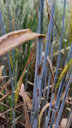

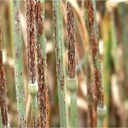

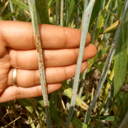

healthy_wheat


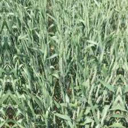

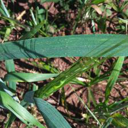

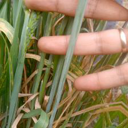

leaf_rust


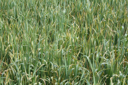

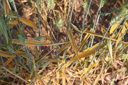

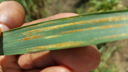

In [4]:
for subdir, dirs, ims in os.walk(train_dir):
    if (subdir != train_dir):
        # Choose random files
        img_list = os.listdir(subdir) 
        number_files = len(img_list)
        img_nums = random.sample(range(number_files), 3)
        print(subdir.split('/')[-1])
        for i in img_nums:
            image = PIL.Image.open(subdir+'/'+img_list[i])
            image.thumbnail([128,128])
            display(image)

## Preprocessing

In this section we format the given train and test image sets to standard form.

In [5]:
base_dir = "data/"
train_dir = "data/train/"
test_dir = "data/test"

# Convert all images to jpg
for subdir, dirs, ims in os.walk(train_dir):
    for im in ims:
        im_path = subdir + os.sep + im
        if im.endswith(".jfif"): 
            im_name, ext = os.path.splitext(im_path)
            im_convert = im_name + ".jpg"
            print(os.path.join(im_path))
            try:
                Image.open(im_path).save(im_convert)
                os.remove(im_path)
            except IOError:
                print("cannot convert", im_path)
            continue
        else:
            continue
            
for subdir, dirs, ims in os.walk(test_dir):
    for im in ims:
        im_path = subdir + os.sep + im
        if im.endswith(".jfif"): 
            im_name, ext = os.path.splitext(im_path)
            im_convert = im_name + ".jpg"
            print(os.path.join(im_path))
            try:
                Image.open(im_path).save(im_convert)
                os.remove(im_path)
            except IOError:
                print("cannot convert", im_path)
            continue
        else:
            continue

Format images as array and reshape to standard size:

In [6]:
def image_to_array(image_path, default_size):
    try:
        im = Image.open(image_path)
        if im is not None:
            out = im.resize(default_size)
            return img_to_array(out)
        else:
            return np.array([])
    except Exception as e:
        print(f"Error : {e}")
        return None

Set up transforms to augment training dataset.

In [7]:
basic_tfms = get_transforms()

Balance unbalanced class distribution in training dataset.

In [8]:
# SMOTE
# Random oversampling of minority class (used for healthy_wheat)

def random_oversample(minority_class, total_images, oversample_tfms):
    minority_dir = 'data/train/' + minority_class + '/'
    oversample_dir = 'data/train/oversample/' + minority_class + '/'

    minority_images = ImageList.from_folder(minority_dir)

    img_list = os.listdir(minority_dir) 
    number_files = len(img_list)
    print("Augmenting",number_files,minority_class,"images to",total_images,"images.")
    total_images = total_images - number_files
    for i in tqdm(range(total_images)):
        img_num = random.sample(range(number_files), 1)
        aug_image = open_image(minority_dir + img_list[img_num[0]])
        aug_image = aug_image.apply_tfms(oversample_tfms[0], aug_image, xtra={oversample_tfms[1][0].tfm: {"size": 224}}, size=224)
        aug_image.save(minority_dir + "oversample_" + str(i) + ".jpg")
        
oversample_tfms = get_transforms(max_rotate=25)
random_oversample('healthy_wheat', 365, oversample_tfms)

# ADASYN

Augmenting 365 healthy_wheat images to 365 images.


Create training/validation data from df.

In [9]:
train_df = pd.DataFrame(columns=['name','label'])

print("Formatting training images to dataframe...")
for subdir, dirs, ims in os.walk(train_dir):
    for im in ims:
        if im.endswith(".jpg") or im.endswith(".JPG"): 
            im_path = subdir + os.sep + im
            
            if subdir.split('/')[-1] == "healthy_wheat":
                img_df = pd.DataFrame({"name": im_path,
                                       "label": ["healthy_wheat"]
                                      })
            elif subdir.split('/')[-1] == "stem_rust":
                img_df = pd.DataFrame({"name": im_path,
                                       "label": ["stem_rust"]
                                      })
            elif subdir.split('/')[-1] == "leaf_rust":
                img_df = pd.DataFrame({"name": im_path,
                                       "label": ["leaf_rust"]
                                      })

            train_df = train_df.append(img_df, sort=True)    
print(train_df)

print("Formatting training dataframe to ImageDataBunch...")
train_data_bunch = ImageDataBunch.from_df(path="./",
                                          df=train_df, 
                                          valid_pct=0.15, 
                                          fn_col="name", 
                                          label_col="label",
                                          size=224,
                                          ds_tfms=basic_tfms)
train_data_bunch.normalize(imagenet_stats)

Formatting training images to dataframe...
        label                             name
0   stem_rust  data/train/stem_rust/QUMDJO.JPG
0   stem_rust  data/train/stem_rust/O03SHZ.jpg
0   stem_rust  data/train/stem_rust/026AEH.JPG
0   stem_rust  data/train/stem_rust/XFVHN1.JPG
0   stem_rust  data/train/stem_rust/3NNNOP.JPG
..        ...                              ...
0   leaf_rust  data/train/leaf_rust/HNDRV1.jpg
0   leaf_rust  data/train/leaf_rust/I11B5N.jpg
0   leaf_rust  data/train/leaf_rust/0W9XLD.JPG
0   leaf_rust  data/train/leaf_rust/5C3950.jpg
0   leaf_rust  data/train/leaf_rust/EANNBM.JPG

[1089 rows x 2 columns]
Formatting training dataframe to ImageDataBunch...


ImageDataBunch;

Train: LabelList (926 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
stem_rust,stem_rust,stem_rust,stem_rust,stem_rust
Path: .;

Valid: LabelList (163 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
healthy_wheat,stem_rust,stem_rust,stem_rust,healthy_wheat
Path: .;

Test: None

Create training data from folder.

In [5]:
#data = ImageDataBunch.from_folder(base_dir, test='test', size=224)
#data.normalize(imagenet_stats)

ImageDataBunch;

Train: LabelList (876 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
stem_rust,stem_rust,stem_rust,stem_rust,stem_rust
Path: data;

Valid: LabelList (537 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
stem_rust,stem_rust,stem_rust,stem_rust,stem_rust
Path: data;

Test: LabelList (610 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: EmptyLabelList
,,,,
Path: data

Confirm image integrity by plotting.

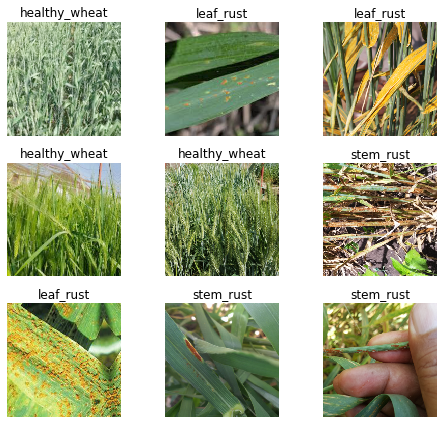

In [10]:
train_data_bunch.show_batch(rows=3, figsize=(7,6))

## Setting up NN model

Create the model: 

In [11]:
learn = cnn_learner(train_data_bunch, models.resnet34, metrics=error_rate)
#learn = cnn_learner(train_data_bunch, tvmodels.resnext50_32x4d, metrics=error_rate)

### Hyperparameter tuning

Learning rate:

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


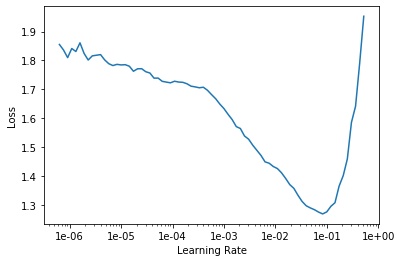

In [29]:
learn.lr_find()
learn.recorder.plot()

## Training Model

In [ ]:
learn.fit_one_cycle(4)

epoch,train_loss,valid_loss,error_rate,time


## Measuring Model

Set up classification interpretation object:

In [12]:
interp = ClassificationInterpretation.from_learner(learn)

Observe "most incorrect".

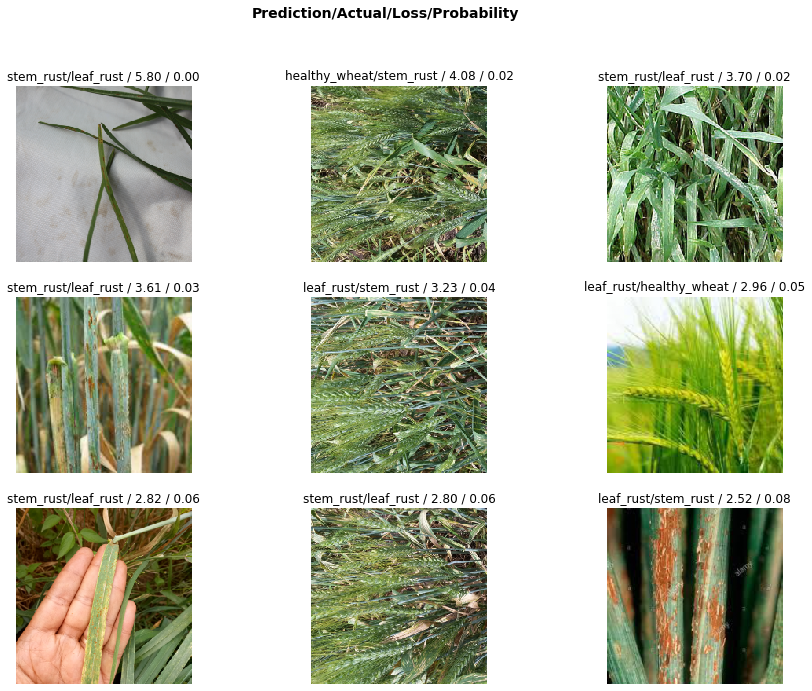

In [13]:
interp.plot_top_losses(9, figsize=(15,11))

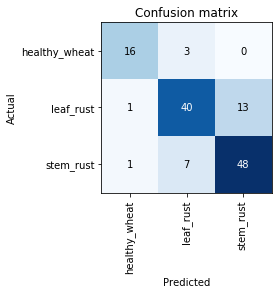

In [14]:
interp.most_confused(min_val=2)
interp.plot_confusion_matrix()

## Making Predictions

Formatting test data:

In [15]:
test_data_bunch = ImageDataBunch.from_folder(base_dir, test='test', size=224)
test_data_bunch.normalize(imagenet_stats)

ImageDataBunch;

Train: LabelList (876 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
stem_rust,stem_rust,stem_rust,stem_rust,stem_rust
Path: data;

Valid: LabelList (537 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
stem_rust,stem_rust,stem_rust,stem_rust,stem_rust
Path: data;

Test: LabelList (610 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: EmptyLabelList
,,,,
Path: data

Making predictions on test data:

In [16]:
pred_df = pd.DataFrame(columns=['ID','healthy_wheat','leaf_rust','stem_rust'])
num = len(test_data_bunch.test_ds)
print("Total test images:\t", num)

for i in tqdm(range(num)):
    filename = str(test_data_bunch.test_ds.items[i]).split('/')[-1].split('.')[0]
    pred = learn.predict(test_data_bunch.test_ds[i][0])
    df2 = pd.DataFrame({"ID": filename,
                        "healthy_wheat": [pred[2][0].item()],
                        "stem_rust": [pred[2][2].item()],
                        "leaf_rust": [pred[2][1].item()]
                        })
    pred_df = pred_df.append(df2, sort=True)

Total test images:	 610


Print predictions to submission format file. 

In [17]:
print(pred_df)
pred_df.to_csv('submission.csv', index=False)

        ID  healthy_wheat  leaf_rust  stem_rust
0   1WP5MJ       0.139002   0.013400   0.847599
0   C3LIDU       0.026210   0.878291   0.095499
0   OS8FB2       0.000833   0.013326   0.985840
0   NS8DVC       0.189942   0.793489   0.016569
0   2G71YU       0.046526   0.885579   0.067895
..     ...            ...        ...        ...
0   Y7VVJU       0.999735   0.000060   0.000205
0   D6TACK       0.004000   0.983497   0.012503
0   UIPPYH       0.026650   0.000153   0.973197
0   BE0SDD       0.000149   0.999753   0.000098
0   UGQ06J       0.193187   0.022896   0.783916

[610 rows x 4 columns]
